# Compare and Analyze Data on COVID-19 Infections Provided by the [Robert Koch Institute (RKI)](https://www.rki.de/EN/Home/homepage_node.html)

The [Robert Koch Institute (RKI)](https://www.rki.de/EN/Home/homepage_node.html) is the federal government agency responsible for disease control and prevention in Germany. Is publishes data about COVID-19 for all of Germany and uses various channels for that (see [this](https://www.rki.de/EN/Content/infections/epidemiology/outbreaks/COVID-19/COVID19.html) page for an overview).

This notebook has been created for analyzing and comparing data from two different sources that are updated by the RKI daily, but have a different level of detail. The main objective is to understand how the very fine grained numbers provided via github can be aggregated such that they match what is shown in the 
[RKI's COVID-19 dashboard](https://corona.rki.de/).

## Preliminaries

In [1]:
import json
import humanize

import datetime as dt
import numpy as np
import pandas as pd
import plotly.express as px

import local_constants as LC

from math import sqrt
from urllib.request import urlopen
from IPython.display import Image

## Load and Analyze Data From the [NPGEO Corona Hub 2020](https://npgeo-corona-npgeo-de.hub.arcgis.com/)

For all German districts, up-to-date COVID-19 data is available via [this](https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0) page. This data appears to be the basis for the [COVID-19 dashboard](https://corona.rki.de/).

### Read Data

In [2]:
# load main data, but restrict the created dataframe to the most relevant columns 
RKI_ARCGIS_COVID_BY_DISTRICT = \
    pd.read_csv(LC.RKI_ARCGIS_URL, usecols=list(LC.RKI_ARCGIS_COLUMN_NAME_MAPPER.keys()))\
        .rename(columns=LC.RKI_ARCGIS_COLUMN_NAME_MAPPER)\
        .sort_values(by="district ID")\
        .set_index("district ID")

# fill missing values
RKI_ARCGIS_COVID_BY_DISTRICT.fillna(method="pad", axis="index", inplace=True)

# convert to datetime64[ns]
RKI_ARCGIS_COVID_BY_DISTRICT["update time"] = pd.to_datetime(RKI_ARCGIS_COVID_BY_DISTRICT["update time"], format="%d.%m.%Y, %H:%M Uhr")

# add column for the number of deaths within the last seven days adjusted to a population size of 100.000 people
RKI_ARCGIS_COVID_BY_DISTRICT["deaths last 7 days per 100k"] = \
    10**5 * RKI_ARCGIS_COVID_BY_DISTRICT["deaths last 7 days"] \
    / RKI_ARCGIS_COVID_BY_DISTRICT["population"]

In [3]:
# print date of most recent entry in the data

print(RKI_ARCGIS_COVID_BY_DISTRICT["update time"].max().strftime("last update is from %Y-%m-%d"))

last update is from 2021-11-05


## Load and Analyze RKI's Data on COVID-19 From [GitHub](https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland)

Repository ["SARS-CoV-2 Infektionen in Deutschland"](https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland) (SARS-CoV-2 Infections in Germany) contains
up-to-date numbers of COVID-19 cases in Germany. The data appears to be what is reported by the districts to the RKI as it lists new cases based on the reporting date, beginning of the disease (reference date), age group, sex and district.

In [Readme.md](https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/blob/master/Readme.md), an explanation for the data is provided (in German). 

### Read Metadata

The RKI publishes metadata based on [zenodo's](https://about.zenodo.org/) JSON format. Here, it is used to detect the publication date of the data. Typically, this is shortly after 3 AM of the current day (local time in Germany). 

In [4]:
RKI_GITHUB_METADATA = json.loads(urlopen(LC.RKI_GITHUB_RAW_DATA_BASE_URL + LC.RKI_GITHUB_ZENODO_REL_URL).read())
RKI_GITHUB_PUBLICATION_DATE = pd.to_datetime(RKI_GITHUB_METADATA["publication_date"])
print(f"publication date is {RKI_GITHUB_PUBLICATION_DATE:%Y-%m-%d %H:%M:%S%z}")

publication date is 2021-11-05 03:09:53+0100


### Read Data

Load data describing COVID-19 infections and deaths etc.

In [5]:
RKI_GITHUB_COVID_INFECTIONS = pd.read_csv(LC.RKI_GITHUB_RAW_DATA_BASE_URL + LC.RKI_GITHUB_COVID_INFECTIONS_REL_URL, 
                                    converters=LC.RKI_GITHUB_VALUE_CONVERTERS)\
                                .rename(columns=LC.RKI_GITHUB_COLUMN_NAME_MAPPER)\
                                .astype(LC.RKI_GITHUB_COLUMN_TYPES_MAPPER)

### Trying to Understand [Readme.md](https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/blob/master/Readme.md)

The text in `Readme.md` states that negative values in column `cases` (`AnzahlFall` in the original data) are for correcting positives cases that have been falsely reported in the past. The same is described for columns
`deaths` (`AnzahlTodesfall` in the original data) and `recovered` (`AnzahlGenesen` in the original data). 

This can be interpreted in a way that the correct number of total cases can be computed by simply adding all values of column `cases`, such that negative values "delete" the cases reported erroneously before. 

In [6]:
print("total cases for Germany considering also negative values:")
print(f' GitHub: {RKI_GITHUB_COVID_INFECTIONS["cases"].sum().sum():,d}')

# sum of all cases in the data from ARCGIS
print(f' ARCGIS: {RKI_ARCGIS_COVID_BY_DISTRICT["cases"].sum():,d}')

total cases for Germany considering also negative values:
 GitHub: 4,709,153
 ARCGIS: 4,709,488


... but this number is **too small**. 

The number that is shown on the dashboard can be retrieved from the data by adding _all positive values_ in column `cases`. 

In [7]:
print("total cases for Germany:")
# print the sum for all positive values in column "cases" 
print(f' GitHub: {RKI_GITHUB_COVID_INFECTIONS.loc[RKI_GITHUB_COVID_INFECTIONS["cases"] > 0, "cases"].sum():,d}')
# sum of all cases in the data from ARCGIS
print(f' ARCGIS: {RKI_ARCGIS_COVID_BY_DISTRICT["cases"].sum():,d}')

total cases for Germany:
 GitHub: 4,709,488
 ARCGIS: 4,709,488


### Compute Totals

Based on the interpretation of the data described above, the sum of columns `cases`, `deaths` and `recovered` is calculated for each district.

For the sake of convenience, a new dataframe is defined, in which negative values for the number of COVID-19 cases, deaths and recovered patients are set to zero. This is used later for the aggregation of data.

In [8]:
# define dataframe that without the negative values in RKI_GITHUB_COVID_INFECTIONS

RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES = \
    pd.concat([RKI_GITHUB_COVID_INFECTIONS[["district ID", "age group", "sex", "reporting date", "reference date"]], 
              RKI_GITHUB_COVID_INFECTIONS[["cases", "deaths", "recovered"]].apply(lambda a: np.maximum(a,0))], 
              axis="columns")

In [9]:
#  sum up "cases", "deaths", "recovered" for each district
RKI_GITHUB_COVID_BY_DISTRICT_TOTALS = \
    RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES[["district ID", "cases", "deaths", "recovered"]].groupby(by="district ID").sum()

# copy population size for each district from RKI_ARCGIS_COVID_BY_DISTRICT
RKI_GITHUB_COVID_BY_DISTRICT_TOTALS["population"] = RKI_ARCGIS_COVID_BY_DISTRICT["population"]

### Compute Numbers per 100K People 

The sums in columns `cases`, `deaths` and `recovered` are normalized by the population size of the district. 
For the district's population size, the data from the [NPGEO Corona Hub 2020](https://npgeo-corona-npgeo-de.hub.arcgis.com/) is used.

In [10]:
# define a new dataframe by dividing the totals by the population size of each district and multiplying that with 100,000

RKI_GITHUB_COVID_BY_DISTRICT_PER_100K = \
    pd.DataFrame(data=10**5 * RKI_GITHUB_COVID_BY_DISTRICT_TOTALS[["cases", "deaths", "recovered"]].values \
                 / np.array(3 * [RKI_GITHUB_COVID_BY_DISTRICT_TOTALS["population"].values]).T,
                 index=RKI_GITHUB_COVID_BY_DISTRICT_TOTALS.index,
                 columns=["cases per 100k", "deaths per 100k", "recovered per 100k"])

### Compute Totals for the Last Seven Days

The values in columns `cases`, `deaths` and `recovered` of the last seven days are summed up.

In [11]:
# define the date of the earlist data that should be considered
number_of_days = 7 
cut_off_date = np.datetime64(RKI_GITHUB_PUBLICATION_DATE.date() - dt.timedelta(days=number_of_days))

# compute sums for data that has been reported on or after the cut_off_date
RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS = \
        RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES\
                .loc[RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES["reporting date"] >= cut_off_date]\
                .groupby(by="district ID").sum()\
                .rename(columns={"cases": "cases last 7 days", "deaths": "deaths last 7 days", "recovered": "recovered last 7 days"})

# ensure that there is data for each district by filling missing data with zeros
# define a dataframe containing the most recent data of each district
df = RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES[["district ID", "reporting date"]].sort_values(by=["district ID", "reporting date"])\
        .groupby(["district ID"]).last()

missing_rows = df.loc[df["reporting date"] < cut_off_date].index.shape[0]
if  missing_rows > 0:
    # there are districts that have not reported data within the last 7 days
    # create dataframe containing the zeroes filling the missing data 
    ddf = pd.DataFrame(data=np.zeros((missing_rows, RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS.shape[1]), dtype=np.int64), 
                       index=df.loc[df["reporting date"] < cut_off_date].index,
                       columns=RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS.columns)
    # append zeros
    RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS = RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS.append(ddf)

### Compute Numbers for the Last Seven Days per 100K People 

normalize the sums for the last seven days by the districts' population size 

In [12]:
# define a new dataframe computing values by dividing the totals for the last seven days by the population size 
# of each district and multiplying it with 100,000
 
RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_PER_100K = \
    pd.DataFrame(data=10**5 * RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS.values / np.array(3 * \
        [RKI_GITHUB_COVID_BY_DISTRICT_TOTALS.loc[RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS.index, "population"]]).T,
        index=RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS.index,
        columns=["cases last 7 days per 100k", "deaths last 7 days per 100k", "recovered last 7 days per 100k"])

### Create a DataFrame Containing all Values Derived From the COVID-19 Data from GitHub

In [13]:
# combine all of the dataframes with data that has been derived from RKI_GITHUB_COVID_INFECTIONS into one dataframe, 
# only columns "district name" and "state name" are taken from RKI_ARCGIS_COVID_BY_DISTRICT

RKI_GITHUB_COVID_BY_DISTRICT = \
    pd.concat([RKI_ARCGIS_COVID_BY_DISTRICT[["district name", "state name"]],
               RKI_GITHUB_COVID_BY_DISTRICT_TOTALS, 
               RKI_GITHUB_COVID_BY_DISTRICT_PER_100K, 
               RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_TOTALS,
               RKI_GITHUB_COVID_BY_DISTRICT_LAST_7_DAYS_PER_100K], axis="columns")

## Verify that Derived Data From the [COVID-19 Data from GitHub](https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland) and the Data From [NPGEO Corona Hub 2020](https://npgeo-corona-npgeo-de.hub.arcgis.com/) are (More or Less) Identical

In [14]:
EPSILON = 10**-11 # threshold for treating float values as zero
common_columns = list(set(RKI_ARCGIS_COVID_BY_DISTRICT.columns) & set(RKI_GITHUB_COVID_BY_DISTRICT.columns)) 
common_numerical_columns = [c for c in common_columns if RKI_GITHUB_COVID_BY_DISTRICT[c].dtypes != object]

# return True, if all the differences between the absolute values in the common numerical columns is smaller than the threshold

np.amax(np.abs(RKI_ARCGIS_COVID_BY_DISTRICT[common_numerical_columns].values \
    - RKI_GITHUB_COVID_BY_DISTRICT[common_numerical_columns].values)) < EPSILON

False

## Show Some Data

Based on the result of the verification above, it seems that the interpretation of the data that is provided via GitHub is correct ... or at least identical with what is shown
in the COVID-19 Dashboard. Hence, the following list the most affected districts in Germany can be assumed to be correct.

In [15]:
n = 30
RKI_GITHUB_COVID_BY_DISTRICT.sort_values(by="cases last 7 days per 100k", ascending=False)\
    .head(n).style.hide_index().format(LC.FORMAT_MAPPER)

district name,state name,cases,deaths,recovered,population,cases per 100k,deaths per 100k,recovered per 100k,cases last 7 days,deaths last 7 days,recovered last 7 days,cases last 7 days per 100k,deaths last 7 days per 100k,recovered last 7 days per 100k
LK Miesbach,Bayern,"7,213",87,"5,356","100,183","7,199.8",86.841081,"5,346.2",717,0,0,715.7,0.000,0.0
LK Mühldorf a.Inn,Bayern,"10,192",169,"8,667","116,483","8,749.8",145.085549,"7,440.6",811,2,8,696.2,1.717,6.9
LK Sonneberg,Thüringen,"5,208",167,"4,323","57,044","9,129.8",292.756469,"7,578.4",393,0,0,688.9,0.000,0.0
LK Sächsische Schweiz-Osterzgebirge,Sachsen,"25,897",998,"21,145","244,722","10,582.2",407.809678,"8,640.4","1,672",0,0,683.2,0.000,0.0
LK Rottal-Inn,Bayern,"10,134",198,"8,760","121,800","8,320.2",162.561576,"7,192.1",798,0,2,655.2,0.000,1.6
LK Traunstein,Bayern,"16,805",228,"14,563","177,485","9,468.4",128.461560,"8,205.2","1,106",0,16,623.2,0.000,9.0
LK Berchtesgadener Land,Bayern,"9,595",110,"8,622","106,327","9,024.0",103.454438,"8,108.9",587,0,11,552.1,0.000,10.3
LK Meißen,Sachsen,"20,666",619,"17,493","240,371","8,597.5",257.518586,"7,277.5","1,325",3,0,551.2,1.248,0.0
LK Dingolfing-Landau,Bayern,"8,164",111,"6,793","97,244","8,395.4",114.145860,"6,985.5",489,0,7,502.9,0.000,7.2
LK Görlitz,Sachsen,"24,193","1,179","20,187","250,558","9,655.6",470.549733,"8,056.8","1,257",0,0,501.7,0.000,0.0


Show sums by state

In [16]:
base_columns = ["cases", "deaths", "recovered"]
last_7_days_columns = [c + " last 7 days" for c in base_columns]
index_column = "state name"
columns = [index_column, "population"] + base_columns + last_7_days_columns
RKI_GITHUB_COVID_BY_STATE = RKI_GITHUB_COVID_BY_DISTRICT[columns].groupby(by=index_column).sum()

per_100k_columns = [c + " per 100k" for c in base_columns]
last_7_days_per_100k_columns = [c + " per 100k" for c in last_7_days_columns]
RKI_GITHUB_COVID_BY_STATE[per_100k_columns + last_7_days_per_100k_columns] = \
    10**5 * RKI_GITHUB_COVID_BY_STATE[base_columns + last_7_days_columns].values\
        / np.array(6 * [RKI_GITHUB_COVID_BY_STATE["population"]]).T
RKI_GITHUB_COVID_BY_STATE.style.format(LC.FORMAT_MAPPER)

,population,cases,deaths,recovered,cases last 7 days,deaths last 7 days,recovered last 7 days,cases per 100k,deaths per 100k,recovered per 100k,cases last 7 days per 100k,deaths last 7 days per 100k,recovered last 7 days per 100k
state name,,,,,,,,,,,,,
Baden-Württemberg,"11,103,043","650,466","11,068","600,490","21,443",14,283,"5,858.4",99.684384,"5,408.3",193.1,0.126,2.5
Bayern,"13,140,183","846,759","16,209","764,333","33,743",27,381,"6,444.0",123.354446,"5,816.8",256.8,0.205,2.9
Berlin,"3,657,463","229,370","3,729","212,678","6,596",8,94,"6,271.3",101.955919,"5,814.9",180.3,0.219,2.6
Brandenburg,"2,531,071","128,659","3,940","116,661","4,547",7,41,"5,083.2",155.665329,"4,609.2",179.6,0.277,1.6
Bremen,"680,130","35,792",534,"34,008",565,1,5,"5,262.5",78.514402,"5,000.2",83.1,0.147,0.7
Hamburg,"1,852,478","100,291","1,831","92,738","2,182",3,8,"5,413.9",98.840580,"5,006.2",117.8,0.162,0.4
Hessen,"6,293,154","361,889","7,895","337,365","8,548",10,101,"5,750.5",125.453787,"5,360.8",135.8,0.159,1.6
Mecklenburg-Vorpommern,"1,610,774","54,846","1,259","50,814","1,912",3,35,"3,404.9",78.161182,"3,154.6",118.7,0.186,2.2
Niedersachsen,"8,003,421","326,801","6,109","308,220","7,591",2,123,"4,083.3",76.329859,"3,851.1",94.8,0.025,1.5


equally, the following totals for all of Germany appear correct

In [17]:
columns = ["population", "cases", "cases last 7 days", "deaths", "deaths last 7 days", "recovered", "recovered last 7 days"]
RKI_GITHUB_COVID_BY_DISTRICT[columns].sum().to_frame().T.style.hide_index().format(LC.FORMAT_MAPPER)

population,cases,cases last 7 days,deaths,deaths last 7 days,recovered,recovered last 7 days
"83,148,406","4,709,488","141,283","96,346",124,"4,342,631","1,730"


likewise, the sums for the last 7 days per 100,000 people can be computed

In [18]:
columns = ["cases last 7 days", "deaths last 7 days", "recovered last 7 days"]
(10**5 * RKI_GITHUB_COVID_BY_DISTRICT[columns].sum() / RKI_GITHUB_COVID_BY_DISTRICT["population"].sum())\
    .to_frame().T.rename(columns={c:c+" per 100k" for c in columns}).style.hide_index().format(LC.FORMAT_MAPPER)

cases last 7 days per 100k,deaths last 7 days per 100k,recovered last 7 days per 100k
169.9,0.149,2.1


For the increase in the numbers of cases, deaths and recovered people within the last day, the data for the previous day is loaded and subtracted from the totals of the current day.

In [19]:
PREVIOUS_DAY = pd.Timestamp(RKI_GITHUB_PUBLICATION_DATE.date() - dt.timedelta(days=1))
RKI_GITHUB_COVID_INFECTIONS_PREVIOUS_DAY \
    = pd.read_csv(LC.RKI_GITHUB_RAW_DATA_BASE_URL + "/Archiv" + \
                  PREVIOUS_DAY.strftime("/%Y-%m-%d_Deutschland_SarsCov2_Infektionen.csv"), 
                  converters=LC.RKI_GITHUB_VALUE_CONVERTERS)\
        .rename(columns=LC.RKI_GITHUB_COLUMN_NAME_MAPPER)\
        .astype(LC.RKI_GITHUB_COLUMN_TYPES_MAPPER)

RKI_GITHUB_COVID_INFECTIONS_PREVIOUS_DAY_WITHOUT_NEGATIVES = \
    pd.concat([RKI_GITHUB_COVID_INFECTIONS_PREVIOUS_DAY[["district ID", "age group", "sex", "reporting date", "reference date"]], 
               RKI_GITHUB_COVID_INFECTIONS_PREVIOUS_DAY[["cases", "deaths", "recovered"]].apply(lambda a: np.maximum(a,0))], 
               axis="columns")
               
(RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES[["cases", "deaths", "recovered"]].sum() 
    - RKI_GITHUB_COVID_INFECTIONS_PREVIOUS_DAY_WITHOUT_NEGATIVES[["cases", "deaths", "recovered"]].sum())\
        .to_frame().T.style.hide_index().format(LC.FORMAT_MAPPER)

cases,deaths,recovered
"37,120",154,"14,266"


### Compute Totals by Age Group and Sex

In order to close this notebook with something that is not mysterious, the total number of cases, deaths and recovered people is computed by age group and sex. 
This is again in sync with the data of the COVID-19 dashboard.

In [20]:
RKI_GITHUB_COVID_BY_AGE_GROUP_AND_SEX_TOTALS = \
    RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES[["age group", "sex", "cases", "deaths", "recovered"]]\
        .groupby(by=["age group", "sex"]).sum()
RKI_GITHUB_COVID_BY_AGE_GROUP_AND_SEX_TOTALS.style.format(LC.FORMAT_MAPPER)

## Compare RKI Data with WHO Data

The World Health Organization (WHO) publishes data on COVID-19 for a large number of countries (see [covid19.who.int](https://covid19.who.int/)), including Germany. Apparently, these numbers differ from each other.
The following analysis quantifies those differences.

In [21]:
# load data from WHO
WHO_COVID_WORLDWIDE = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv", parse_dates=["Date_reported"])\
                        .rename(columns=LC.WHO_COLUMN_NAME_MAPPER).set_index("reporting date")

In [22]:
# verify that the cumulative sums for Germany are correct
assert (WHO_COVID_WORLDWIDE[WHO_COVID_WORLDWIDE["country"] == "Germany"][["cases", "deaths"]]\
            .cumsum().rename(columns={"cases":"cumulative cases", "deaths":"cumulative deaths"}) == \
            WHO_COVID_WORLDWIDE[WHO_COVID_WORLDWIDE["country"] == "Germany"][["cumulative cases", "cumulative deaths"]]).all().all()

In [23]:
# define a start and end date that covers all the data available from RKI and WHO

START_DATE = min(RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES["reporting date"].min(), 
                 WHO_COVID_WORLDWIDE[WHO_COVID_WORLDWIDE["country"] == "Germany"].index.min())
END_DATE = max(RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES["reporting date"].max(), 
                 WHO_COVID_WORLDWIDE[WHO_COVID_WORLDWIDE["country"] == "Germany"].index.max())
DATE_RANGE = pd.date_range(start=START_DATE, end=END_DATE)

In [24]:
# define DataFrames with identical structure for the data from RKI and WHO on COVID-19 cases and deaths in Germany

RKI_COVID_GERMANY = RKI_GITHUB_COVID_INFECTIONS_WITHOUT_NEGATIVES[["reporting date", "cases", "deaths"]]\
                        .groupby(by="reporting date").sum().reindex(index=DATE_RANGE)
WHO_COVID_GERMANY = WHO_COVID_WORLDWIDE[WHO_COVID_WORLDWIDE["country"] == "Germany"][["cases", "deaths"]]\
                        .reindex(index=DATE_RANGE)

Due to possible delays in the transmission and processing of data, it is likely that the time axis (index `reporting date`) is not in aligned for the two sets of data. Hence a optimal time shift of the WHO's data is computed based on the euclidean distance of the two vectors.

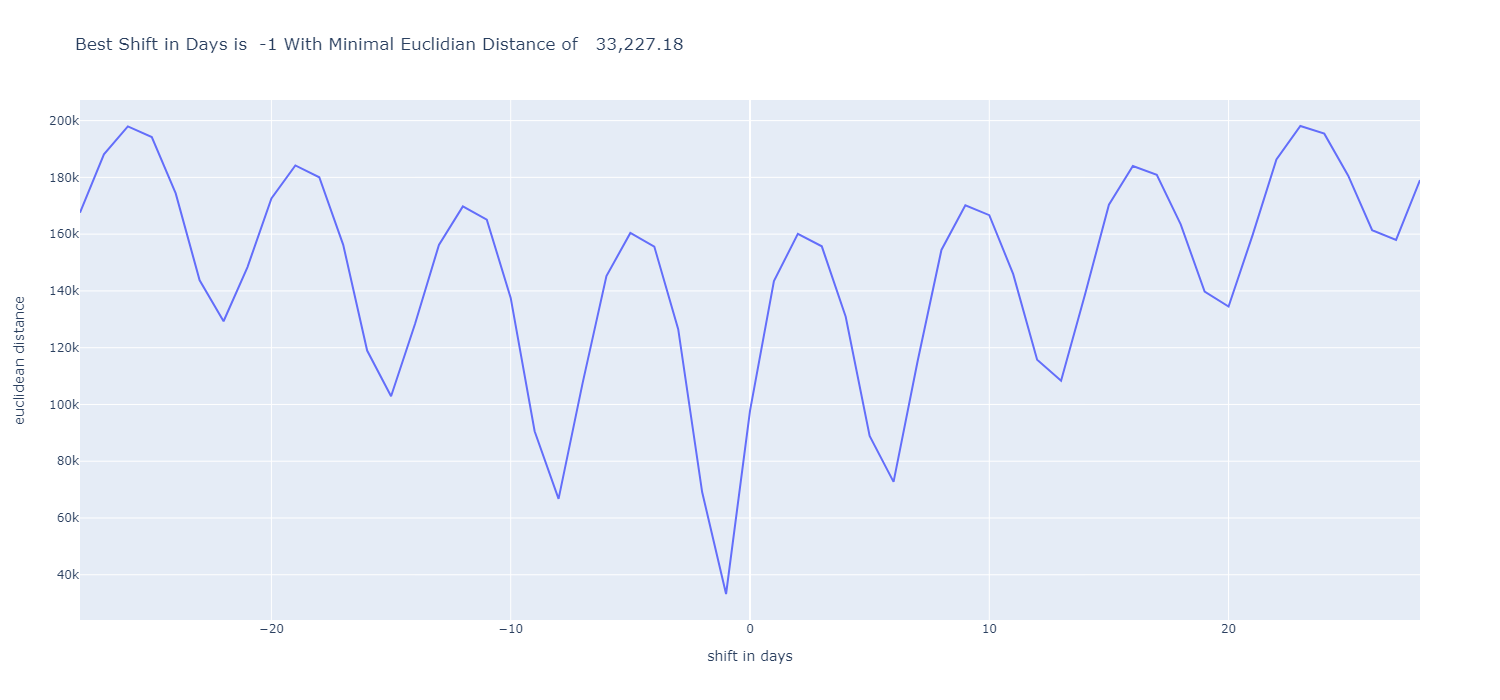

In [31]:
# determine best shift (as multiplies of one day) for the WHO-data, so that the euclidean distance for cases
# and deaths combined is minimal
IMAGE_WIDTH, IMAGE_HEIGHT=1500,700
window, best_shift, min_distance, x, y =  28, None, float("Inf"), [], []
for shift in range(-window,window+1):
    distance = sqrt(np.nansum(np.square((RKI_COVID_GERMANY \
                                         - WHO_COVID_GERMANY.shift(periods=shift, freq=dt.timedelta(days=1))).values)))
    x.append(shift)
    y.append(distance)
    if distance < min_distance:
        best_shift, min_distance = shift, distance

fig = px.line(pd.DataFrame(data={"x": x, "y":y}), x="x", y="y", 
                     title=f"Best Shift in Days is {best_shift:+3d} With Minimal Euclidian Distance of {min_distance:11,.2f}",
                     labels={"y": "euclidean distance", "x": "shift in days"})
img_bytes = fig.to_image(format="png",  width=IMAGE_WIDTH, height=IMAGE_HEIGHT)
display(Image(img_bytes))

WHO_SHIFT = dt.timedelta(days=best_shift)
WHO_COVID_GERMANY_SHIFTED = WHO_COVID_GERMANY.shift(periods=best_shift, freq=dt.timedelta(days=1)).reindex(index=DATE_RANGE)

after aligning the data as good as possible, there should be difference in the total number of COVID-19 cases and deaths - unfortunately, this is not the case ...

In [26]:
print("Difference in Totals Between Data From RKI and WHO for the Timeframe From"\
        + f"{humanize.naturaldate(START_DATE)} Until {humanize.naturaldate(END_DATE + WHO_SHIFT)}")

df = pd.DataFrame(data=RKI_COVID_GERMANY.loc[START_DATE:END_DATE + WHO_SHIFT].sum().to_dict(), index=["RKI"])
df = df.append(pd.DataFrame(data=WHO_COVID_GERMANY_SHIFTED.loc[START_DATE:END_DATE + WHO_SHIFT].sum().to_dict(), index=["WHO"]))
df = df.append(pd.DataFrame((df.iloc[0] - df.iloc[1]).to_dict(), index=["difference"]))
df.style.format("{:,.0f}")

Difference in Totals Between Data From RKI and WHO for the Timeframe FromJan 02 2020 Until yesterday


,cases,deaths
RKI,"4,709,488","96,346"
WHO,"4,709,488","96,346"
difference,0,0


maybe there is some obvious flaw, which can be see in the diagram showing the differences of a daily basis ...

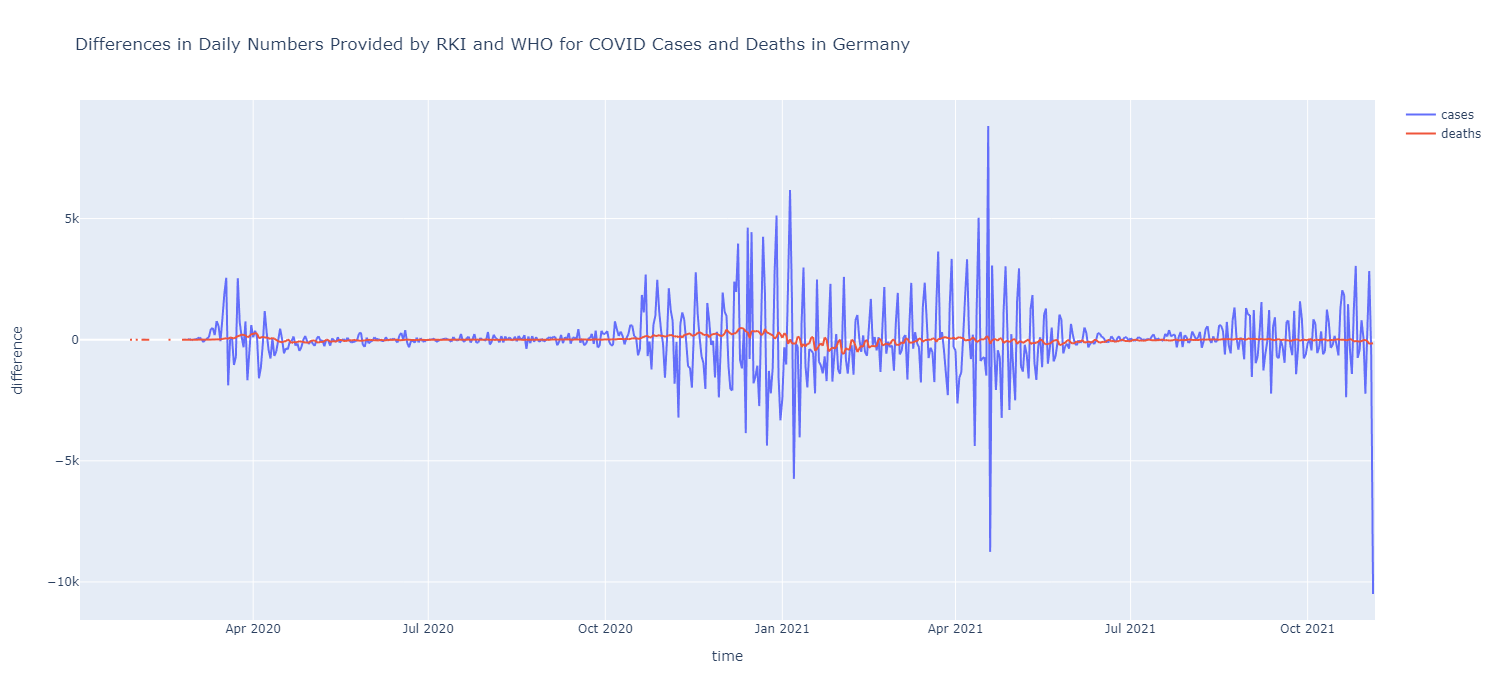

In [27]:
fig = px.line((RKI_COVID_GERMANY 
               - WHO_COVID_GERMANY_SHIFTED).reset_index(), x="index", y=["cases", "deaths"], 
               title="Differences in Daily Numbers Provided by RKI and WHO for COVID Cases and Deaths in Germany", 
               labels={"value": "difference", "index": "time", "variable": ""})

img_bytes = fig.to_image(format="png",  width=IMAGE_WIDTH, height=IMAGE_HEIGHT)
Image(img_bytes)

compare "smoothed" data

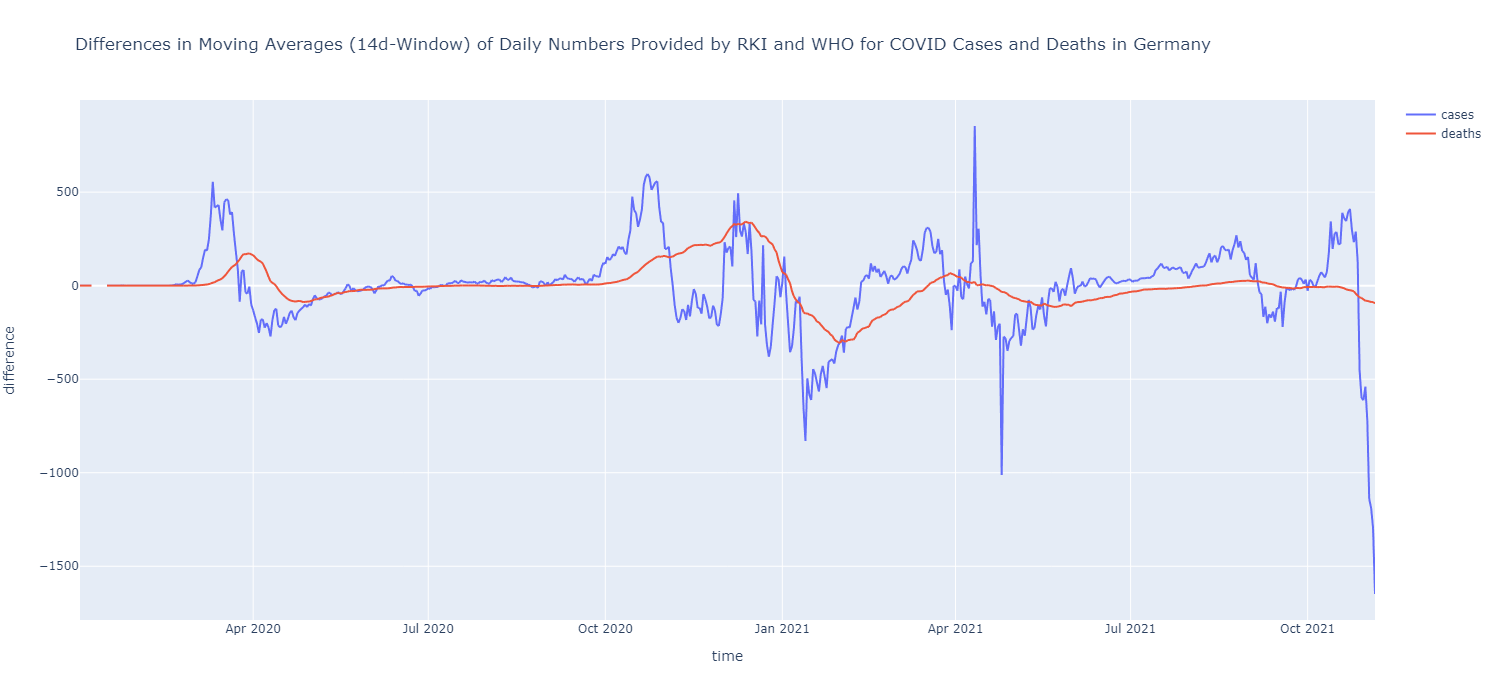

In [28]:
window = '14d'
fig = px.line((RKI_COVID_GERMANY.rolling(window, center=True, min_periods=1).mean() 
               - WHO_COVID_GERMANY_SHIFTED.rolling(window, center=True, min_periods=1).mean()).reset_index(), 
               x="index", y=["cases", "deaths"], 
               title=f"Differences in Moving Averages ({window}-Window) of Daily Number"+
                      "Provided by RKI and WHO for COVID Cases and Deaths in Germany", 
               labels={"value": "difference", "index": "time", "variable": ""})
img_bytes = fig.to_image(format="png",  width=IMAGE_WIDTH, height=IMAGE_HEIGHT)
Image(img_bytes)

show differences in the data sets based on the cumulative sum of cases and deaths

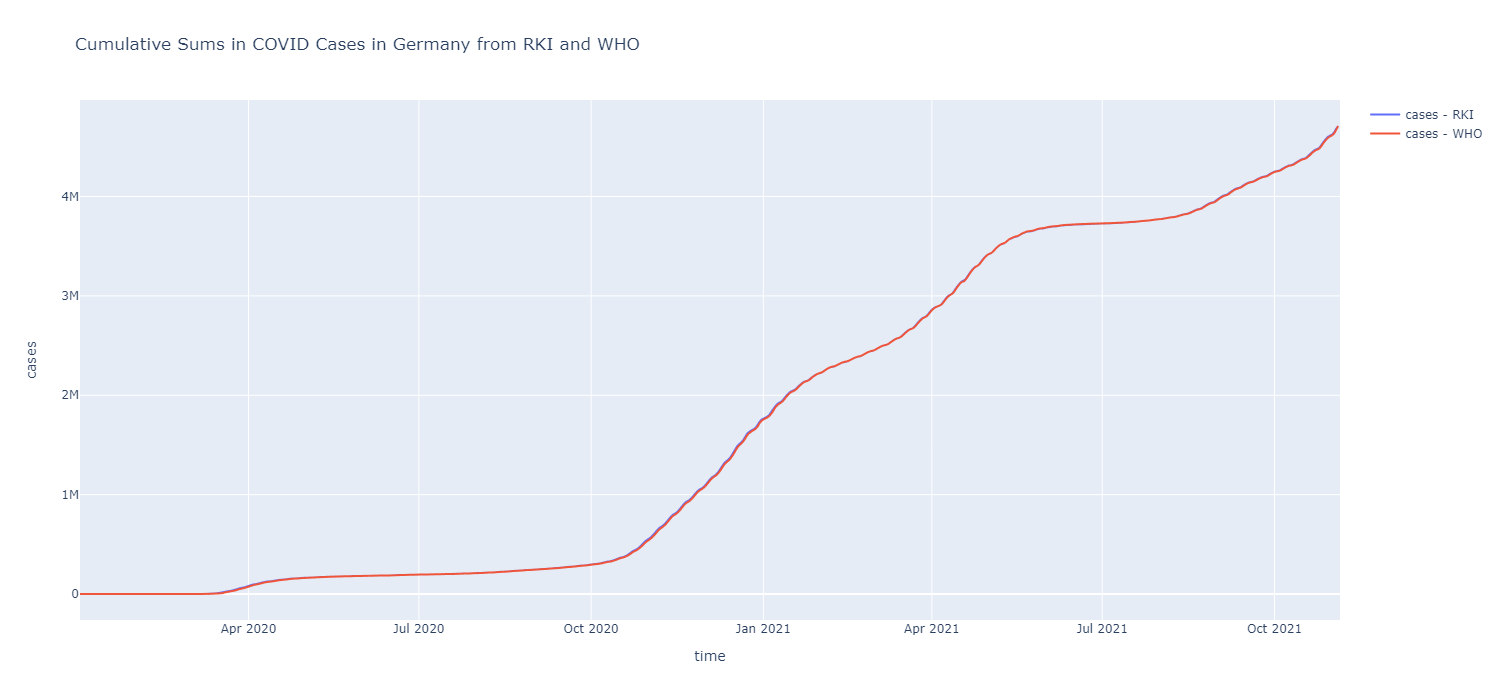

In [29]:
column = "cases"
df = pd.concat([RKI_COVID_GERMANY[[column]].cumsum().rename(columns={column: column + " - RKI"}),\
                WHO_COVID_GERMANY_SHIFTED[[column]].cumsum().rename(columns={column: column + " - WHO"})], axis="columns").reset_index()
fig = px.line(df, x="index", y=[column + " - RKI", column + " - WHO"], 
                title=f"Cumulative Sums in COVID {column.capitalize()} in Germany from RKI and WHO",
        labels={"value": column, "index": "time", "variable": ""})
img_bytes = fig.to_image(format="png",  width=IMAGE_WIDTH, height=IMAGE_HEIGHT)
Image(img_bytes)

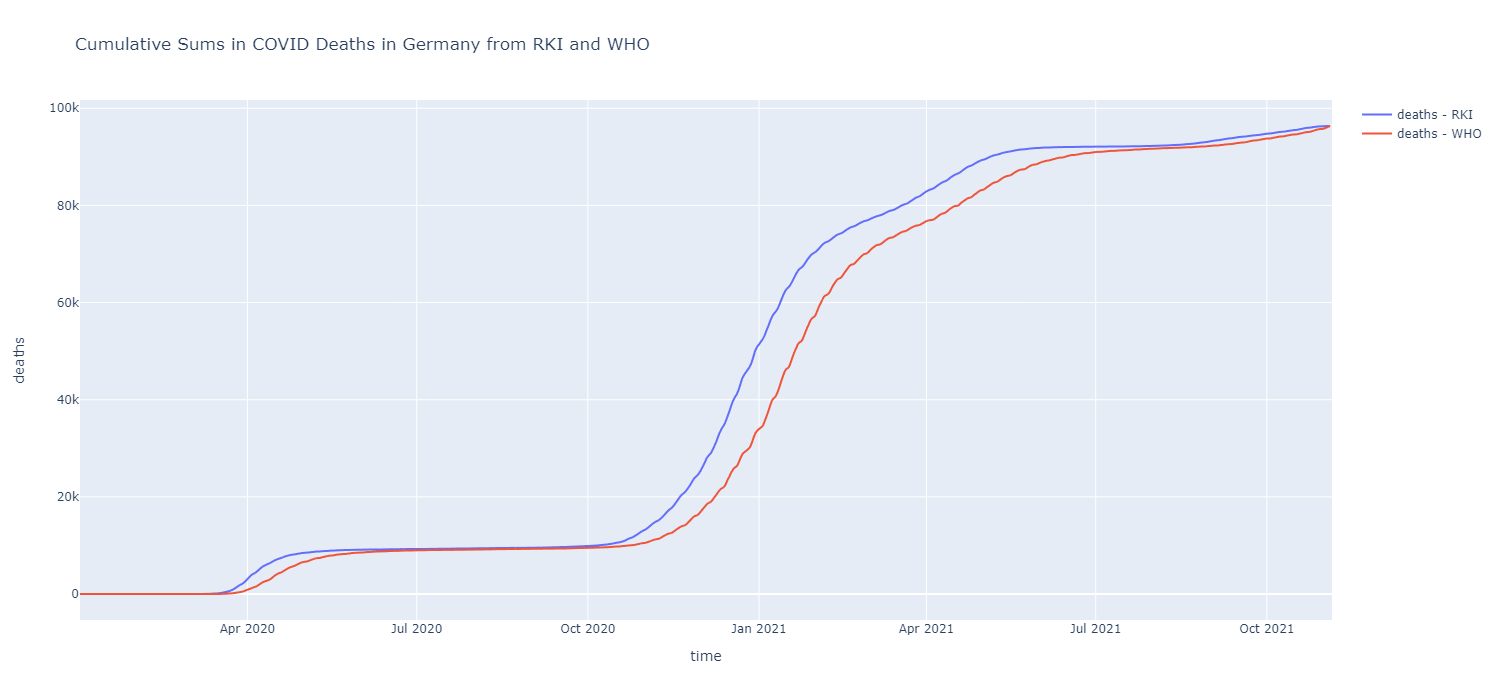

In [30]:
column = "deaths"
df = pd.concat([RKI_COVID_GERMANY[[column]].cumsum().rename(columns={column: column + " - RKI"}),\
                WHO_COVID_GERMANY_SHIFTED[[column]].cumsum().rename(columns={column: column + " - WHO"})], axis="columns").reset_index()
fig = px.line(df, x="index", y=[column + " - RKI", column + " - WHO"], 
              title=f"Cumulative Sums in COVID {column.capitalize()} in Germany from RKI and WHO",
              labels={"value": column, "index": "time", "variable": ""})
img_bytes = fig.to_image(format="png",  width=IMAGE_WIDTH, height=IMAGE_HEIGHT)
Image(img_bytes)